In [2]:
import os

QM9_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/filtered_QM9_charges_radicals_stereo.smi"
ChEMBL_CNOF_path = os.environ["DATA"] + "/00_datasets/ChEMBL25/filtered_ChEMBL_charges_radicals_stereo_CNOF.smi"

output_fig_path = os.environ["FIGURES"] + "/07_BBO/04_BBO_chem/01_QED/"

os.makedirs(output_fig_path, exist_ok=True)

In [3]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct

kernels = [
    ("RBF", 1.0*RBF(1.0) + WhiteKernel(1.0)),
    ("DotProduct", 1.0*DotProduct(1.0) + WhiteKernel(1.0))
]

In [4]:
import csv
from evomol.evaluation import QEDEvaluationStrategy
import numpy as np

def load_smiles_dataset(path):
    
    all_smiles = []
    
    with open(path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            all_smiles.append(row[0])
            
    np.random.shuffle(all_smiles)
    return all_smiles
        

def compute_QED(dataset_smiles):
    
    s = QEDEvaluationStrategy()
    return [s.eval_smi(smi) for smi in dataset_smiles]

In [5]:
QM9_smiles = load_smiles_dataset(QM9_path)
ChEMBL_smiles = load_smiles_dataset(ChEMBL_CNOF_path)

print(len(QM9_smiles))
print(len(ChEMBL_smiles))

132040
867606


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
    
    

In [10]:
def eval_model(model, X_train, y_train, X_test, y_test, size):
    
    tstart = time.time()
    model.fit(X_train[:size], y_train[:size])
    fit_time = time.time() - tstart
    
    tstart = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - tstart
    
    MAE = np.mean(np.absolute(y_pred - y_test))
    
    return MAE, fit_time, predict_time
    

def data_efficiency_experiments(kernels, QM9_smiles, ChEMBL_smiles):
    
    output_dict = {kernel[0]: {
        "size": [],
        "QM9_fit_time": [],
        "QM9_predict_time": [],
        "QM9_MAE": [],
        "ChEMBL_fit_time": [],
        "ChEMBL_predict_time": [],
        "ChEMBL_MAE": []
    } for kernel in kernels}
    
    dataset_sizes = [10, 30, 100, 300, 1000, 3000, 10000]
    
    desc_builer = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    qed_eval = QEDEvaluationStrategy()
    
    QM9_train_smiles, QM9_test_smiles = train_test_split(QM9_smiles, test_size=50000)
    ChEMBL_train_smiles, ChEMBL_test_smiles = train_test_split(ChEMBL_smiles, test_size=50000)
    
    QM9_train_smiles = QM9_train_smiles[:10000]
    ChEMBL_train_smiles = ChEMBL_train_smiles[:10000]
    
    QM9_train_X = desc_builer.fit_transform(QM9_train_smiles)[0]
    QM9_test_X = desc_builer.fit_transform(QM9_test_smiles)[0]
    ChEMBL_train_X = desc_builer.fit_transform(ChEMBL_train_smiles)[0]
    ChEMBL_test_X = desc_builer.fit_transform(ChEMBL_test_smiles)[0]
    
    QM9_train_X = np.array([d[:100] for d in QM9_train_X])
    QM9_test_X = np.array([d[:100] for d in QM9_test_X])
    ChEMBL_train_X = np.array([d[:100] for d in ChEMBL_train_X])
    ChEMBL_test_X = np.array([d[:100] for d in ChEMBL_test_X])

    print(QM9_train_X.shape)
    
    QM9_train_y = [qed_eval.eval_smi(smi) for smi in tqdm(QM9_train_smiles)]
    QM9_test_y = [qed_eval.eval_smi(smi) for smi in tqdm(QM9_test_smiles)]
    ChEMBL_train_y = [qed_eval.eval_smi(smi) for smi in tqdm(ChEMBL_train_smiles)]
    ChEMBL_test_y = [qed_eval.eval_smi(smi) for smi in tqdm(ChEMBL_test_smiles)]
    
    for kernel in kernels:
        print(kernel[0])
        model = GaussianProcessRegressor(kernel=kernel[1], normalize_y=True)
        
        for dataset_size in dataset_sizes:
            print(dataset_size)
            
            MAE_QM9, time_fit_QM9, time_predict_QM9 = eval_model(model, QM9_train_X, QM9_train_y, 
                                                                 QM9_test_X, QM9_test_y, 
                                                                 dataset_size)
            
            MAE_ChEMBL, time_fit_ChEMBL, time_predict_ChEMBL = eval_model(model, ChEMBL_train_X, ChEMBL_train_y, 
                                                                          ChEMBL_test_X, ChEMBL_test_y, 
                                                                          dataset_size)
            print(time_fit_ChEMBL)
            output_dict[kernel[0]]["size"].append(dataset_size)
            output_dict[kernel[0]]["QM9_fit_time"].append(time_fit_QM9)
            output_dict[kernel[0]]["QM9_predict_time"].append(time_predict_QM9)
            output_dict[kernel[0]]["QM9_MAE"].append(MAE_QM9)
            output_dict[kernel[0]]["ChEMBL_fit_time"].append(time_fit_ChEMBL)
            output_dict[kernel[0]]["ChEMBL_predict_time"].append(time_predict_ChEMBL)
            output_dict[kernel[0]]["ChEMBL_MAE"].append(MAE_ChEMBL)
            
    return output_dict
            

In [11]:
output_data_efficiency = data_efficiency_experiments(kernels, QM9_smiles, ChEMBL_smiles)

MM program : obabel_mmff94
None


  0%|          | 9/10000 [00:00<01:53, 88.30it/s]

(10000, 100)


100%|██████████| 50000/50000 [01:58<00:00, 422.22it/s]


RBF
10
0.014367341995239258
30
0.0738515853881836
100
0.08302474021911621
300
0.2039775848388672
1000
1.6149024963378906
3000
21.45337677001953
10000
408.9172828197479
DotProduct
10
0.05802559852600098
30
0.10301876068115234
100
0.06168246269226074
300
0.11299633979797363
1000
2.0436644554138184
3000
16.56161093711853
10000
311.9912283420563


In [12]:
def time_desc(QM9_smiles, ChEMBL_smiles):
        
    desc_builer = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    
    _, QM9_test_smiles = train_test_split(QM9_smiles, test_size=50000)
    _, ChEMBL_test_smiles = train_test_split(ChEMBL_smiles, test_size=50000)
    
    tstart = time.time()
    desc_builer.fit_transform(QM9_test_smiles)
    time_QM9_desc = time.time() - tstart
    
    tstart = time.time()
    desc_builer.fit_transform(ChEMBL_test_smiles)
    time_ChEMBL_desc = time.time() - tstart
    
    return time_QM9_desc, time_ChEMBL_desc

In [13]:
time_QM9_desc, time_ChEMBL_desc = time_desc(QM9_smiles, ChEMBL_smiles)

MM program : obabel_mmff94
None


100%|██████████| 50000/50000 [07:12<00:00, 115.58it/s]


In [14]:
time_QM9_desc/50

2.553101725578308

In [15]:
time_ChEMBL_desc/50

8.652894186973572

In [16]:
import numpy as np
import pandas as pd
from os.path import join



def plot_data_efficiency(output_data_efficiency, time_QM9_desc, time_ChEMBL_desc):
    
    d = {"size": [], "Données": [], "predict_time": [], "desc_predict_time": [], "fit_time": [], "MAE": [], 
         "Noyau": []} 
    
    k = "RBF"
    
    predict_time_denominateur = 50
    
    for k in ["RBF", "DotProduct"]:
        d["size"].extend(output_data_efficiency[k]["size"])
        d["Données"].extend(np.full(len(output_data_efficiency[k]["size"],), "QM9"))
        d["Noyau"].extend(np.full(len(output_data_efficiency[k]["size"],), k))
        d["fit_time"].extend(output_data_efficiency[k]["QM9_fit_time"])
        d["predict_time"].extend(np.array(output_data_efficiency[k]["QM9_predict_time"])/predict_time_denominateur)
        d["desc_predict_time"].extend(np.array(output_data_efficiency[k]["QM9_predict_time"])/predict_time_denominateur + time_QM9_desc/predict_time_denominateur)
        d["MAE"].extend(output_data_efficiency[k]["QM9_MAE"])

        d["size"].extend(output_data_efficiency[k]["size"])
        d["Données"].extend(np.full(len(output_data_efficiency[k]["size"],), "ChEMBL"))
        d["Noyau"].extend(np.full(len(output_data_efficiency[k]["size"],), k))
        d["fit_time"].extend(output_data_efficiency[k]["ChEMBL_fit_time"])
        d["predict_time"].extend(np.array(output_data_efficiency[k]["ChEMBL_predict_time"])/predict_time_denominateur)
        d["desc_predict_time"].extend(np.array(output_data_efficiency[k]["ChEMBL_predict_time"])/predict_time_denominateur + time_ChEMBL_desc/predict_time_denominateur)
        d["MAE"].extend(output_data_efficiency[k]["ChEMBL_MAE"])

        
    df = pd.DataFrame.from_dict(d)

   
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=df, x="size", y="MAE", hue="Données", style="Noyau", legend="brief")
    plt.ylabel("Erreur moyenne absolue (MAE)")
    plt.xlabel("Taille des données d'entraînement")
    plt.ylim(0, 0.2)
    
    plt.savefig(join(output_fig_path, "desc_100_MAE.png"), dpi=250)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6), sharex=True) #sharey=True)

    
#     handles, labels = ax1.get_legend_handles_labels()
#     ax1.legend(handles=handles[:2], labels=labels, title="Whatever else")
#     ax1.legend(handles=handles[2:4], labels=labels, title="Whatever else")
    

    sns.lineplot(x="size", y="fit_time", hue="Données", style="Noyau", data=df[df["Données"] == "QM9"], ax=ax1, legend=False)
    sns.lineplot(x="size", y="predict_time", hue="Données", style="Noyau", data=df[df["Données"] == "QM9"], ax=ax2, legend=False)
    sns.lineplot(x="size", y="desc_predict_time", hue="Données", style="Noyau", data=df, ax=ax3)
    
    ax1.set_xlabel("Taille des données d'entraînement")
    ax1.set_ylabel("Temps (s)")
    ax1.set_yscale("log")
    ax1.set_ylim(1e-3, 1e4)
    ax1.set_title("Entraînement")
    
    ax2.set_xlabel("Taille des données d'entraînement")
    ax2.set_ylabel("")
    ax2.set_yscale("log")
    ax2.set_ylim(1e-3, 1e4)
    ax2.set_title("Prédiction (1000 mol.)")
    
    ax3.set_xlabel("Taille des données d'entraînement")
    ax3.set_ylabel("")
    ax3.set_yscale("log")
    ax3.set_ylim(1e-3, 1e4)
    ax3.set_title("Descripteurs + prédiction (1000 mol.)")
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(join(output_fig_path, "desc_100_times.png"), dpi=250)
    
    return df

size Données  predict_time  desc_predict_time    fit_time       MAE  \
0      10     QM9      0.000882           2.553983    0.082009  0.057843   
1      30     QM9      0.002205           2.555307    0.062530  0.054043   
2     100     QM9      0.006361           2.559463    0.063231  0.045742   
3     300     QM9      0.016608           2.569710    0.230434  0.038007   
4    1000     QM9      0.054991           2.608093    2.679364  0.031287   
5    3000     QM9      0.195738           2.748839   36.465272  0.027794   
6   10000     QM9      0.727206           3.280308  437.614516  0.023758   
7      10  ChEMBL      0.001427           8.654321    0.014367  0.195005   
8      30  ChEMBL      0.002165           8.655059    0.073852  0.173802   
9     100  ChEMBL      0.005795           8.658689    0.083025  0.128305   
10    300  ChEMBL      0.016745           8.669639    0.203978  0.109191   
11   1000  ChEMBL      0.054783           8.707678    1.614902  0.092042   
12   3000  ChEMBL      0.177632           8.830526   21.453377  0.082462   
13  10000  ChEMBL      0.732401           9.385296  408.917283  0.073252   
14     10     QM9      0.000366           2.553468    0.063977  0.057816   
15     30     QM9      0.000462           2.553564    0.067075  0.057743   
16    100     QM9      0.001423           2.554525    0.118356  0.043276   
17    300     QM9      0.003096           2.556198    0.162776  0.040534   
18   1000     QM9      0.009531           2.562633    2.596935  0.037601   
19   3000     QM9      0.024297           2.577398   19.626696  0.036538   
20  10000     QM9      0.065980           2.619082  415.400035  0.036183   
21     10  ChEMBL      0.000221           8.653116    0.058026  0.195351   
22     30  ChEMBL      0.000368           8.653262    0.103019  0.203100   
23    100  ChEMBL      0.001298           8.654192    0.061682  0.137052   
24    300  ChEMBL      0.003298           8.656192    0.112996  0.121099   
25   1000  ChEMBL      0.009418           8.662312    2.043664  0.113036   
26   3000  ChEMBL      0.023913           8.676807   16.561611  0.109533   
27  10000  ChEMBL      0.066079           8.718973  311.991228  0.108345   

         Noyau  
0          RBF  
1          RBF  
2          RBF  
3          RBF  
4          RBF  
5          RBF  
6          RBF  
7          RBF  
8          RBF  
9          RBF  
10         RBF  
11         RBF  
12         RBF  
13         RBF  
14  DotProduct  
15  DotProduct  
16  DotProduct  
17  DotProduct  
18  DotProduct  
19  DotProduct  
20  DotProduct  
21  DotProduct  
22  DotProduct  
23  DotProduct  
24  DotProduct  
25  DotProduct  
26  DotProduct  
27  DotProduct

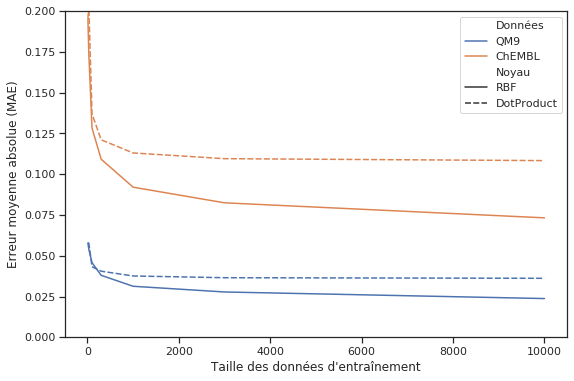

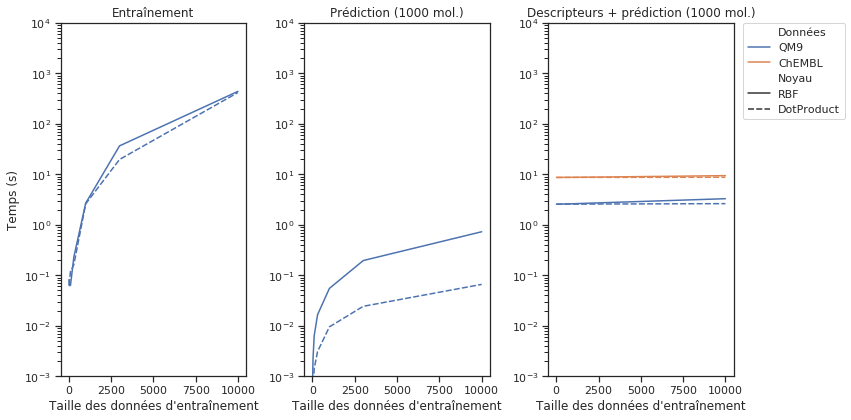

In [17]:
plot_data_efficiency(output_data_efficiency, time_QM9_desc, time_ChEMBL_desc)

In [18]:
output_data_efficiency

{'RBF': {'size': [10, 30, 100, 300, 1000, 3000, 10000],
  'QM9_fit_time': [0.08200931549072266,
   0.0625295639038086,
   0.06323051452636719,
   0.23043417930603027,
   2.67936372756958,
   36.465272426605225,
   437.614515542984],
  'QM9_predict_time': [0.04407835006713867,
   0.1102743148803711,
   0.31805968284606934,
   0.8304080963134766,
   2.7495572566986084,
   9.786875486373901,
   36.36029529571533],
  'QM9_MAE': [0.0578425584275048,
   0.05404311439244666,
   0.045742171115053104,
   0.038006540082401744,
   0.031286786773395026,
   0.02779416482379578,
   0.023758073313183227],
  'ChEMBL_fit_time': [0.014367341995239258,
   0.0738515853881836,
   0.08302474021911621,
   0.2039775848388672,
   1.6149024963378906,
   21.45337677001953,
   408.9172828197479],
  'ChEMBL_predict_time': [0.0713341236114502,
   0.10822558403015137,
   0.28975629806518555,
   0.8372459411621094,
   2.739166498184204,
   8.881591081619263,
   36.620073556900024],
  'ChEMBL_MAE': [0.1950046763601239